- boxcox하게되면 큰값으로 쏠림 -> 중간으로 몰고와야함
- https://discuss.huggingface.co/t/training-a-regression-model-using-roberta-smiles-to-ccs-cheminformatics/1314

# Setting

In [1]:
import sys
sys.path.append('/Volumes/KHJ/Github/hyuckjinkim/lib-python')

In [2]:
from base import gc_collect_all
from data_prepare import (
    get_holiday, reduce_mem_usage, delete_unique_columns,
    TypeController, CategoricalQuantileCalculator,
    GroupScaler, OneHotEncoder, InteractionTerm, TargetTransform,
)

In [3]:
gc_collect_all()

In [4]:
from tqdm import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import datetime

pd.set_option('mode.chained_assignment',  None)

In [5]:
def global_assignment(dictionary):
    for k,v in dictionary.items():
        exec("globals()['{}']=dictionary['{}']".format(k,k))

In [6]:
def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

In [7]:
def abline(intercept,slope):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, linestyle='--', color='red')

In [8]:
def identity(x):
    return x

class TargetTransform:
    def __init__(self,func='identity'):
        assert func in ['identity','log','sqrt'], \
            print("func must be one of ['identity','log','sqrt']")
        self.func = func
        self.inv_func = {'log':'exp','sqrt':'square'}.get('log','Unknown')
        
        if self.func=='identity':
            self.transform_fn = identity
            self.inverse_transform_fn = identity
        else:
            self.transform_fn = eval('np.{}'.format(self.func))
            self.inverse_transform_fn = eval('np.{}'.format(self.inv_func))
        
    def _get_offset(self,x):
        x = np.array(x)
        if min(x)>0:
            offset = 0
        elif min(x)==0:
            offset = 1e-3
        else:
            offset = -min(x)+1e-3
        return offset
        
    def fit(self,target):
        if self.func=='identity':
            self.offsets = np.zeros(np.array(target).shape[1])
        else:
            self.offsets = []
            for i in range(np.array(target).shape[1]):
                x = np.array(target)[:,i]
                offset = self._get_offset(x)
                self.offsets.append(offset)
    
    def transform(self,target):
        res = []
        for i in range(np.array(target).shape[1]):
            x = np.array(target)[:,i]
            x = self.transform_fn(x+self.offsets[i])
            res.append(x)
        return np.array(res).T
    
    def fit_transform(self,target):
        self.fit(target)
        return self.transform(target)
    
    def inverse_transform(self,target):
        res = []
        for i in range(np.array(target).shape[1]):
            x = np.array(target)[:,i]
            x = self.inverse_transform_fn(x) - self.offsets[i]
            res.append(x)
        return np.array(res).T

<br></br>

# Configuration

In [9]:
class CFG:
    TARGET = ['MLM','HLM']
    SEGMENT = None
    
    # kfold
    SEED = 0
    N_SPLITS = 5

<br></br>

# Data Load

In [10]:
train_df = pd.read_csv('./data/train.csv')
test_df  = pd.read_csv('./data/test.csv')

In [11]:
train_df.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43


<br></br>

# EDA

In [12]:
# train_df.describe()

In [13]:
# num_features = train_df.columns[train_df.dtypes!='object'].tolist()
# for i,col in enumerate(num_features):

#     fig = plt.figure(figsize=(15,7))
#     fig.add_subplot(121)
#     sns.histplot(train_df[col],bins=20)
#     plt.grid()

#     fig.add_subplot(122)
#     sns.histplot(np.log(train_df[col]+1e-3),bins=20)
#     plt.grid()

#     plt.suptitle('[{}/{}] {}'.format(i+1,len(num_features),col))
#     plt.tight_layout()
#     plt.show()

# # -> ['Molecular_Weight','Molecular_PolarSurfaceArea']

In [14]:
# cols = ['AlogP','Molecular_Weight','Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds','LogD','Molecular_PolarSurfaceArea']
# for col in cols:
#     print(col)
#     plt.figure(figsize=(15,7))
#     sns.scatterplot(x=train_df[col],y=train_df['HLM'])
#     plt.grid()
#     plt.show()

In [15]:
# cols = ['Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds']
# for col in cols:
#     print(col)
#     plt.figure(figsize=(15,7))
#     sns.boxplot(x=train_df[col],y=train_df.MLM)
#     plt.show()

In [16]:
# train_df.nunique()

In [17]:
# lists = sorted(train_df['Num_H_Acceptors'].unique())
# for v in lists:
#     print('########',v)
#     d = train_df[train_df['Num_H_Acceptors']==v]
    
#     cols = ['AlogP','Molecular_Weight','Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds','LogD','Molecular_PolarSurfaceArea']
#     for col in cols:
#         print(col)
#         plt.figure(figsize=(15,7))
#         sns.scatterplot(x=d[col],y=d['HLM'])
#         plt.grid()
#         plt.show()

<br></br>

# Data Preprocess

- [Dacon](https://dacon.io/competitions/official/236127/talkboard/409051?page=1&dtype=recent)에 따르면 100이 넘는 값도 나올 수 있음

In [18]:
# targets = ['MLM','HLM']
# for t in targets:
#     train_df[t] = [0 if x<0 else
#                    100 if x>100 else
#                    x for x in train_df[t]]

<br>

In [19]:
from rdkit import DataStructs
from rdkit.Chem import PandasTools, AllChem

In [20]:
# 화학구조 이미지 생성
PandasTools.AddMoleculeColumnToFrame(train_df,'SMILES','Molecule')
PandasTools.AddMoleculeColumnToFrame(test_df ,'SMILES','Molecule')

In [21]:
# Molecule to MorganFingerprint
def mol2fp(mol):
    #radius, nBits = 6, 4096
    radius, nBits = 2, 512
    fp = AllChem.GetHashedMorganFingerprint(mol, radius=radius, nBits=nBits)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar

In [22]:
# FPs column 추가
train_df["FPs"] = train_df.Molecule.apply(mol2fp)
test_df ["FPs"] = test_df .Molecule.apply(mol2fp)

In [23]:
from sklearn.feature_selection import VarianceThreshold

In [24]:
feature_select = VarianceThreshold(threshold=0.01)

# 일부사용
tr_fps_selected = feature_select.fit_transform(np.stack(train_df['FPs']))
te_fps_selected = feature_select.transform(np.stack(test_df['FPs']))

# # 전체사용
# tr_fps_selected = np.stack(train_df['FPs'])
# te_fps_selected = np.stack(test_df ['FPs'])

fps_names = ['fps'+str(i+1) for i in range(tr_fps_selected.shape[1])]
print(len(fps_names))

train_df = pd.concat([
    train_df.drop('FPs',axis=1),
    pd.DataFrame(tr_fps_selected,columns=fps_names),
],axis=1)

test_df = pd.concat([
    test_df.drop('FPs',axis=1),
    pd.DataFrame(te_fps_selected,columns=fps_names),
],axis=1)

512


In [25]:
train_df['fps_raw_avg'] = np.mean(train_df[fps_names].values,axis=1)
test_df ['fps_raw_avg'] = np.mean(test_df [fps_names].values,axis=1)

In [26]:
# fps_dummy_names = []
# for col in fps_names:
#     train_df[f'{col}_dmy'] = np.where(train_df[col]==0,0,1)
#     test_df [f'{col}_dmy'] = np.where(test_df [col]==0,0,1)
#     fps_dummy_names.append(f'{col}_dmy')

In [27]:
# train_df['fps_dummy_sum'] = np.sum(train_df[fps_dummy_names].values,axis=1)
# test_df ['fps_dummy_sum'] = np.sum(test_df [fps_dummy_names].values,axis=1)

In [28]:
# 사용할 column만 추출
unuse_features = ['id','SMILES','Molecule']
num_features = [col for col in train_df.columns if col not in unuse_features+CFG.TARGET]

train_df.drop(unuse_features,axis=1,inplace=True)
test_df .drop(unuse_features,axis=1,inplace=True)

In [29]:
train_df.shape

(3498, 522)

In [30]:
train_df.head()

,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,fps1,fps2,fps3,fps4,fps5,fps6,fps7,fps8,fps9,fps10,fps11,fps12,fps13,fps14,fps15,fps16,fps17,fps18,fps19,fps20,fps21,fps22,fps23,fps24,fps25,fps26,fps27,fps28,fps29,fps30,fps31,fps32,fps33,fps34,fps35,fps36,fps37,fps38,fps39,fps40,fps41,fps42,fps43,fps44,fps45,fps46,fps47,fps48,fps49,fps50,fps51,fps52,fps53,fps54,fps55,fps56,fps57,fps58,fps59,fps60,fps61,fps62,fps63,fps64,fps65,fps66,fps67,fps68,fps69,fps70,fps71,fps72,fps73,fps74,fps75,fps76,fps77,fps78,fps79,fps80,fps81,fps82,fps83,fps84,fps85,fps86,fps87,fps88,fps89,fps90,fps91,fps92,fps93,fps94,fps95,fps96,fps97,fps98,fps99,fps100,fps101,fps102,fps103,fps104,fps105,fps106,fps107,fps108,fps109,fps110,fps111,fps112,fps113,fps114,fps115,fps116,fps117,fps118,fps119,fps120,fps121,fps122,fps123,fps124,fps125,fps126,fps127,fps128,fps129,fps130,fps131,fps132,fps133,fps134,fps135,fps136,fps137,fps138,fps139,fps140,fps141,fps142,fps143,fps144,fps145,fps146,fps147,fps148,fps149,fps150,fps151,fps152,fps153,fps154,fps155,fps156,fps157,fps158,fps159,fps160,fps161,fps162,fps163,fps164,fps165,fps166,fps167,fps168,fps169,fps170,fps171,fps172,fps173,fps174,fps175,fps176,fps177,fps178,fps179,fps180,fps181,fps182,fps183,fps184,fps185,fps186,fps187,fps188,fps189,fps190,fps191,fps192,fps193,fps194,fps195,fps196,fps197,fps198,fps199,fps200,fps201,fps202,fps203,fps204,fps205,fps206,fps207,fps208,fps209,fps210,fps211,fps212,fps213,fps214,fps215,fps216,fps217,fps218,fps219,fps220,fps221,fps222,fps223,fps224,fps225,fps226,fps227,fps228,fps229,fps230,fps231,fps232,fps233,fps234,fps235,fps236,fps237,fps238,fps239,fps240,fps241,fps242,fps243,fps244,fps245,fps246,fps247,fps248,fps249,fps250,fps251,fps252,fps253,fps254,fps255,fps256,fps257,fps258,fps259,fps260,fps261,fps262,fps263,fps264,fps265,fps266,fps267,fps268,fps269,fps270,fps271,fps272,fps273,fps274,fps275,fps276,fps277,fps278,fps279,fps280,fps281,fps282,fps283,fps284,fps285,fps286,fps287,fps288,fps289,fps290,fps291,fps292,fps293,fps294,fps295,fps296,fps297,fps298,fps299,fps300,fps301,fps302,fps303,fps304,fps305,fps306,fps307,fps308,fps309,fps310,fps311,fps312,fps313,fps314,fps315,fps316,fps317,fps318,fps319,fps320,fps321,fps322,fps323,fps324,fps325,fps326,fps327,fps328,fps329,fps330,fps331,fps332,fps333,fps334,fps335,fps336,fps337,fps338,fps339,fps340,fps341,fps342,fps343,fps344,fps345,fps346,fps347,fps348,fps349,fps350,fps351,fps352,fps353,fps354,fps355,fps356,fps357,fps358,fps359,fps360,fps361,fps362,fps363,fps364,fps365,fps366,fps367,fps368,fps369,fps370,fps371,fps372,fps373,fps374,fps375,fps376,fps377,fps378,fps379,fps380,fps381,fps382,fps383,fps384,fps385,fps386,fps387,fps388,fps389,fps390,fps391,fps392,fps393,fps394,fps395,fps396,fps397,fps398,fps399,fps400,fps401,fps402,fps403,fps404,fps405,fps406,fps407,fps408,fps409,fps410,fps411,fps412,fps413,fps414,fps415,fps416,fps417,fps418,fps419,fps420,fps421,fps422,fps423,fps424,fps425,fps426,fps427,fps428,fps429,fps430,fps431,fps432,fps433,fps434,fps435,fps436,fps437,fps438,fps439,fps440,fps441,fps442,fps443,fps444,fps445,fps446,fps447,fps448,fps449,fps450,fps451,fps452,fps453,fps454,fps455,fps456,fps457,fps458,fps459,fps460,fps461,fps462,fps463,fps464,fps465,fps466,fps467,fps468,fps469,fps470,fps471,fps472,fps473,fps474,fps475,fps476,fps477,fps478,fps479,fps480,fps481,fps482,fps483,fps484,fps485,fps486,fps487,fps488,fps489,fps490,fps491,fps492,fps493,fps494,fps495,fps496,fps497,fps498,fps499,fps500,fps501,fps502,fps503,fps504,fps505,fps506,fps507,fps508,fps509,fps510,fps511,fps512,fps_raw_avg
0,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,1,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0

In [31]:
test_df.head()

,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,fps1,fps2,fps3,fps4,fps5,fps6,fps7,fps8,fps9,fps10,fps11,fps12,fps13,fps14,fps15,fps16,fps17,fps18,fps19,fps20,fps21,fps22,fps23,fps24,fps25,fps26,fps27,fps28,fps29,fps30,fps31,fps32,fps33,fps34,fps35,fps36,fps37,fps38,fps39,fps40,fps41,fps42,fps43,fps44,fps45,fps46,fps47,fps48,fps49,fps50,fps51,fps52,fps53,fps54,fps55,fps56,fps57,fps58,fps59,fps60,fps61,fps62,fps63,fps64,fps65,fps66,fps67,fps68,fps69,fps70,fps71,fps72,fps73,fps74,fps75,fps76,fps77,fps78,fps79,fps80,fps81,fps82,fps83,fps84,fps85,fps86,fps87,fps88,fps89,fps90,fps91,fps92,fps93,fps94,fps95,fps96,fps97,fps98,fps99,fps100,fps101,fps102,fps103,fps104,fps105,fps106,fps107,fps108,fps109,fps110,fps111,fps112,fps113,fps114,fps115,fps116,fps117,fps118,fps119,fps120,fps121,fps122,fps123,fps124,fps125,fps126,fps127,fps128,fps129,fps130,fps131,fps132,fps133,fps134,fps135,fps136,fps137,fps138,fps139,fps140,fps141,fps142,fps143,fps144,fps145,fps146,fps147,fps148,fps149,fps150,fps151,fps152,fps153,fps154,fps155,fps156,fps157,fps158,fps159,fps160,fps161,fps162,fps163,fps164,fps165,fps166,fps167,fps168,fps169,fps170,fps171,fps172,fps173,fps174,fps175,fps176,fps177,fps178,fps179,fps180,fps181,fps182,fps183,fps184,fps185,fps186,fps187,fps188,fps189,fps190,fps191,fps192,fps193,fps194,fps195,fps196,fps197,fps198,fps199,fps200,fps201,fps202,fps203,fps204,fps205,fps206,fps207,fps208,fps209,fps210,fps211,fps212,fps213,fps214,fps215,fps216,fps217,fps218,fps219,fps220,fps221,fps222,fps223,fps224,fps225,fps226,fps227,fps228,fps229,fps230,fps231,fps232,fps233,fps234,fps235,fps236,fps237,fps238,fps239,fps240,fps241,fps242,fps243,fps244,fps245,fps246,fps247,fps248,fps249,fps250,fps251,fps252,fps253,fps254,fps255,fps256,fps257,fps258,fps259,fps260,fps261,fps262,fps263,fps264,fps265,fps266,fps267,fps268,fps269,fps270,fps271,fps272,fps273,fps274,fps275,fps276,fps277,fps278,fps279,fps280,fps281,fps282,fps283,fps284,fps285,fps286,fps287,fps288,fps289,fps290,fps291,fps292,fps293,fps294,fps295,fps296,fps297,fps298,fps299,fps300,fps301,fps302,fps303,fps304,fps305,fps306,fps307,fps308,fps309,fps310,fps311,fps312,fps313,fps314,fps315,fps316,fps317,fps318,fps319,fps320,fps321,fps322,fps323,fps324,fps325,fps326,fps327,fps328,fps329,fps330,fps331,fps332,fps333,fps334,fps335,fps336,fps337,fps338,fps339,fps340,fps341,fps342,fps343,fps344,fps345,fps346,fps347,fps348,fps349,fps350,fps351,fps352,fps353,fps354,fps355,fps356,fps357,fps358,fps359,fps360,fps361,fps362,fps363,fps364,fps365,fps366,fps367,fps368,fps369,fps370,fps371,fps372,fps373,fps374,fps375,fps376,fps377,fps378,fps379,fps380,fps381,fps382,fps383,fps384,fps385,fps386,fps387,fps388,fps389,fps390,fps391,fps392,fps393,fps394,fps395,fps396,fps397,fps398,fps399,fps400,fps401,fps402,fps403,fps404,fps405,fps406,fps407,fps408,fps409,fps410,fps411,fps412,fps413,fps414,fps415,fps416,fps417,fps418,fps419,fps420,fps421,fps422,fps423,fps424,fps425,fps426,fps427,fps428,fps429,fps430,fps431,fps432,fps433,fps434,fps435,fps436,fps437,fps438,fps439,fps440,fps441,fps442,fps443,fps444,fps445,fps446,fps447,fps448,fps449,fps450,fps451,fps452,fps453,fps454,fps455,fps456,fps457,fps458,fps459,fps460,fps461,fps462,fps463,fps464,fps465,fps466,fps467,fps468,fps469,fps470,fps471,fps472,fps473,fps474,fps475,fps476,fps477,fps478,fps479,fps480,fps481,fps482,fps483,fps484,fps485,fps486,fps487,fps488,fps489,fps490,fps491,fps492,fps493,fps494,fps495,fps496,fps497,fps498,fps499,fps500,fps501,fps502,fps503,fps504,fps505,fps506,fps507,fps508,fps509,fps510,fps511,fps512,fps_raw_avg
0,2.641,361.505,4,2,7,2.635,92.76,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,

<br>

## Imputation

In [32]:
def check_null(data):
    d = data.copy()

    null_info = d\
        .isnull().sum()\
        .reset_index()\
        .rename(columns={'index':'feature',0:'null_cnt'})

    null_info = null_info[null_info['null_cnt']!=0]
    null_info['null_percentage'] = 100 * null_info['null_cnt'] / len(train_df)
    null_info = null_info.sort_values('null_cnt',ascending=False).round(2)
    
    return null_info

In [33]:
check_null(train_df)

,feature,null_cnt,null_percentage
2,AlogP,2,0.06


In [34]:
from sklearn.impute import SimpleImputer

impute_columns = ['AlogP']
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
train_df[impute_columns] = imputer.fit_transform(train_df[impute_columns])
test_df [impute_columns] = imputer.transform(test_df[impute_columns])

In [35]:
# train_df.drop('AlogP',axis=1,inplace=True)
# test_df .drop('AlogP',axis=1,inplace=True)

In [36]:
check_null(train_df)

,feature,null_cnt,null_percentage


<br>

## Target Transformation

In [37]:
inverse_transform = None

(1) log transformation

In [38]:
# target_transform = TargetTransform(func=CFG.TARGET_TRANSFORMATION)
# train_df[CFG.TARGET] = target_transform.fit_transform(
#     target=train_df[CFG.TARGET],
# )

(2) boxcox transformation

In [39]:
# from scipy.special import boxcox, inv_boxcox

# def boxcox_transform(x,lam=0.25):
#     return boxcox(x,lam)

# def inverse_boxcox_transform(x,lam=0.25):
#     return inv_boxcox(x,lam)

In [40]:
# inverse_transform = inverse_boxcox_transform

In [41]:
# y = train_df['HLM'].copy()
# y = boxcox_transform(y,0.45)

# print(y.isnull().sum())

# plt.figure(figsize=(15,7))
# plt.hist(y,bins=50)
# plt.grid()
# plt.show()

In [42]:
# for col in CFG.TARGET:
#     train_df[col] = boxcox_transform(train_df[col])

In [43]:
# train_df[CFG.TARGET].isnull().sum()

In [44]:
# inverse_transform(train_df[CFG.TARGET]).isnull().sum()

<br>

## Interaction Term

In [45]:
# num_features = [col for col in train_df.columns if col not in targets]
# len(num_features)

In [46]:
# interaction_maker = InteractionTerm()
# interaction_maker.fit(
#     data=train_df,
#     num_features=num_features,
#     corr_cutoff=0.10,
# )
# train_df = interaction_maker.transform(train_df)
# test_df  = interaction_maker.transform(test_df)

In [47]:
train_df.shape

(3498, 522)

<br>

## Memory Reduce

In [48]:
train_df, _ = reduce_mem_usage(train_df,verbose=False)
test_df , _ = reduce_mem_usage(test_df ,verbose=False)

In [49]:
train_df.to_parquet('./out/train_df.parquet')
test_df .to_parquet('./out/test_df.parquet')

<br></br>

# Modeling

## Weighted Ensemble

In [50]:
train_df = pd.read_parquet('./out/train_df.parquet')
test_df = pd.read_parquet('./out/test_df.parquet')

In [51]:
train_fn = train_df.copy()
test_fn  = test_df .copy()

In [52]:
# https://stackoverflow.com/questions/66785587/how-do-i-use-validation-sets-on-multioutputregressor-for-xgbregressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.multioutput import MultiOutputRegressor

from sklearn.utils.validation import _check_fit_params
from sklearn.base import is_classifier
from sklearn.utils.fixes import delayed
from joblib import Parallel
from sklearn.multioutput import _fit_estimator

class Evalset_MultiOutputRegressor(MultiOutputRegressor):
    
    def fit(self, X, y, sample_weight=None, **fit_params):
        """ Fit the model to data.
        Fit a separate model for each output variable.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Data.
        y : {array-like, sparse matrix} of shape (n_samples, n_outputs)
            Multi-output targets. An indicator matrix turns on multilabel
            estimation.
        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights. If None, then samples are equally weighted.
            Only supported if the underlying regressor supports sample
            weights.
        **fit_params : dict of string -> object
            Parameters passed to the ``estimator.fit`` method of each step.
            .. versionadded:: 0.23
        Returns
        -------
        self : object
        """

        if not hasattr(self.estimator, "fit"):
            raise ValueError("The base estimator should implement"
                             " a fit method")

        X, y = self._validate_data(X, y,
                                   force_all_finite=False,
                                   multi_output=True, accept_sparse=True)

        if is_classifier(self):
            check_classification_targets(y)

        if y.ndim == 1:
            raise ValueError("y must have at least two dimensions for "
                             "multi-output regression but has only one.")

        if (sample_weight is not None and
                not has_fit_parameter(self.estimator, 'sample_weight')):
            raise ValueError("Underlying estimator does not support"
                             " sample weights.")

        fit_params_validated = _check_fit_params(X, fit_params)
        [(X_test, Y_test)] = fit_params_validated.pop('eval_set')
        self.estimators_ = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_estimator)(
                self.estimator, X, y[:, i], sample_weight,
                **fit_params_validated, eval_set=[(X_test, Y_test[:, i])]) #.iloc로 수정
            for i in range(y.shape[1]))
        return self

In [53]:
from copy import deepcopy
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.multioutput import MultiOutputRegressor
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import time
import pickle

class WeightedEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,hyperparameters,weight=['equal','balanced'],inverse_transform=None):
        super().__init__()
        
        assert weight in ['equal','balanced'], \
            "weight must be one of ['equal','balanced']"
        
        self.hyperparameters = hyperparameters
        self.weight = weight
        self.inverse_transform = inverse_transform
        self._get_regressors()
    
    def _get_regressors(self):
        params_ridge = {
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=CFG.N_SPLITS, n_repeats=3, random_state=CFG.SEED),
        }
        
        params_lasso = {
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=CFG.N_SPLITS, n_repeats=3, random_state=CFG.SEED),
            'n_jobs' : -1,
            #'max_iter' : 30000,
            'tol' : 0.001,
        }
        
        params_elasticnet = {
            'l1_ratio' : np.arange(0.1, 1, 0.1),
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=CFG.N_SPLITS, n_repeats=3, random_state=CFG.SEED),
            'n_jobs' : -1,
            #'max_iter' : 30000,
            'tol' : 0.001,
        }
        
        params_xgboost = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            #'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'reg:squarederror',
            'verbosity' : 0,
            'max_depth': self.hyperparameters['max_depth'],
            'n_jobs' : -1,
        }
    
        params_lightgbm = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            #'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'n_jobs' : -1,
        }
        
        params_extratrees = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations']//10,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'n_jobs' : -1,
        }
        
        params_catboost1 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'MultiRMSE',
            'eval_metric': 'MultiRMSE',
            'grow_policy' : 'Lossguide',
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 1,
        }
        
        params_catboost2 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'MultiRMSE',
            'eval_metric': 'MultiRMSE',
            'grow_policy' : 'Lossguide',
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 3,
        }
        
        params_catboost3 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'MultiRMSE',
            'eval_metric': 'MultiRMSE',
            'grow_policy' : 'Lossguide',
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 5,
        }
        
        params_catboost4 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'MultiRMSE',
            'eval_metric': 'MultiRMSE',
            'grow_policy' : 'Depthwise',
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 1,
        }
        
        params_catboost5 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'MultiRMSE',
            'eval_metric': 'MultiRMSE',
            'grow_policy' : 'Depthwise',
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 3,
        }
        
        params_catboost6 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'MultiRMSE',
            'eval_metric': 'MultiRMSE',
            'grow_policy' : 'Depthwise',
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 5,
        }
        
        self.regressors = [
            #MultiOutputRegressor(LinearRegression()),
            #MultiOutputRegressor(RidgeCV(**params_ridge)),
            #MultiOutputRegressor(LassoCV(**params_lasso)),
            MultiOutputRegressor(ElasticNetCV(**params_elasticnet)),
            Evalset_MultiOutputRegressor(XGBRegressor(**params_xgboost)),
            Evalset_MultiOutputRegressor(LGBMRegressor(**params_lightgbm)),
            MultiOutputRegressor(ExtraTreesRegressor(**params_extratrees)),
            CatBoostRegressor(**params_catboost1),
            CatBoostRegressor(**params_catboost2),
            CatBoostRegressor(**params_catboost3),
            CatBoostRegressor(**params_catboost4),
            CatBoostRegressor(**params_catboost5),
            CatBoostRegressor(**params_catboost6),
        ]
        self.regressors_name = [
            #'OLS',
            #'Ridge',
            #'Lasso',
            'ElasticNet',
            'XGBoost',
            'LightGBM',
            'ExtraTrees',
            'CatBoost1',
            'CatBoost2',
            'CatBoost3',
            'CatBoost4',
            'CatBoost5',
            'CatBoost6',
        ]
        
    def _set_zero_to_minimum(self,pred,minimum_value):
        pred = np.array(pred).flatten()
        if np.where(pred<0,1,0).sum()>0:
            pred = [x if x>0 else minimum_value for x in pred]
        pred = np.array(pred).flatten()
        pred = pred.reshape(len(pred)//2,2)
        return pred
    
    def _set_inf_to_maximum(self,pred,maximum_value):
        pred = np.array(pred).flatten()
        if np.where(pred==np.inf,1,0).sum()>0:
            pred = [x if x!=np.inf else maximum_value for x in pred]
        pred = np.array(pred).flatten()
        pred = pred.reshape(len(pred)//2,2)
        return pred
    
    def _set_0to100(self,pred):
        pred = np.array(pred).flatten()
        if np.where((pred<0)|(pred>100),1,0).sum()>0:
            pred = [0 if x<0 else
                    100 if x>100 else
                    x for x in pred]
        pred = np.array(pred).flatten()
        pred = pred.reshape(len(pred)//2,2)
        return pred
    
    def fit(self,X,y,eval_set,oh_set,cat_features,verbose=1):
        assert len(eval_set)==1, \
            "eval_set length must be 1. len(eval_set)={}".format(len(eval_set))
        assert len(oh_set)==1, \
            "oh_set length must be 1. len(oh_set)={}".format(len(oh_set))
        X_val, y_val = eval_set[0]
        X_oh, X_val_oh = oh_set[0]
        
        self.features = X.columns
        self.oh_features = X_oh.columns
        
        tr_true = np.array(y)
        va_true = np.array(y_val)
        if self.inverse_transform is not None:
            tr_true = self.inverse_transform(tr_true)
            va_true = self.inverse_transform(va_true)
        
        self.minimum_value = min(np.nanmin(y),np.nanmin(y_val))
        self.maximum_value = max(np.nanmax(y),np.nanmax(y_val))
        
        self.cat_features = cat_features
        self.scores = []
        self.weights = []
        self.fitting_elapsed = []
        if verbose:
            pbar = tqdm(zip(self.regressors_name,self.regressors),total=len(self.regressors))
        else:
            pbar = zip(self.regressors_name,self.regressors)
            
        fit_iter = 0
        for regressor_name,regressor in pbar:
            fit_iter+=1
            s = time.time()
            
            if verbose:
                pbar.set_description(name)
                
            if regressor_name in ['OLS','Ridge','Lasso','ElasticNet']:
                warnings.filterwarnings("ignore", category=UserWarning)
                regressor.fit(X_oh,y)
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            elif regressor_name.find('CatBoost')>=0:
                train_dataset = Pool(X,y,cat_features=cat_features)
                val_dataset   = Pool(X_val,y_val,cat_features=cat_features)
                regressor.fit(
                    train_dataset,
                    eval_set=val_dataset,
                    #metric_period=self.hyperparameters['iterations']//50,
                    #verbose=True,
                )
                tr_pred = regressor.predict(train_dataset)
                va_pred = regressor.predict(val_dataset)
            elif regressor_name=='XGBoost':
                fit_params = {
                    'eval_set':[(X_val_oh.values,y_val.values)],
                    'early_stopping_rounds':self.hyperparameters['early_stopping_rounds'],
                    'verbose':0,
                }
                regressor.fit(
                    X_oh.values,y.values,
                    **fit_params,
                )
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            elif regressor_name=='LightGBM':
                warnings.filterwarnings("ignore", category=UserWarning)
                X_tmp = X.copy()
                X_val_tmp = X_val.copy()
                for col in cat_features:
                    X_tmp[col]     = X_tmp[col]    .astype('category')
                    X_val_tmp[col] = X_val_tmp[col].astype('category')
                fit_params = {
                    'eval_set':[(X_val_tmp.values,y_val.values)],
                    'early_stopping_rounds':self.hyperparameters['early_stopping_rounds'],
                    'verbose':0,
                }
                regressor.fit(
                    X_tmp.values,y.values,
                    **fit_params,
                )
                tr_pred = regressor.predict(X_tmp)
                va_pred = regressor.predict(X_val_tmp)
            elif regressor_name=='ExtraTrees':
                regressor.fit(X_oh.values,y.values)
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            else:
                raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
            tr_pred = np.array(tr_pred)
            va_pred = np.array(va_pred)
            
            #tr_pred = self._set_zero_to_minimum(tr_pred,self.minimum_value)
            #va_pred = self._set_zero_to_minimum(va_pred,self.minimum_value)
            
            if self.inverse_transform is not None:
                tr_pred = self.inverse_transform(tr_pred)
                va_pred = self.inverse_transform(va_pred)
                tr_pred = self._set_inf_to_maximum(tr_pred,self.maximum_value)
                va_pred = self._set_inf_to_maximum(va_pred,self.maximum_value)
                
            #tr_pred = self._set_0to100(tr_pred)
            #va_pred = self._set_0to100(va_pred)
            
            global _tr_pred, _va_pred, _tr_true, _va_true
            _tr_pred,_va_pred = tr_pred,va_pred
            _tr_true,_va_true = tr_true,va_true
            
            tr_score_1 = mean_squared_error(y_true=tr_true[:,0],y_pred=tr_pred[:,0])**0.5
            tr_score_2 = mean_squared_error(y_true=tr_true[:,1],y_pred=tr_pred[:,1])**0.5
            va_score_1 = mean_squared_error(y_true=va_true[:,0],y_pred=va_pred[:,0])**0.5
            va_score_2 = mean_squared_error(y_true=va_true[:,1],y_pred=va_pred[:,1])**0.5
            tr_score = 0.5*tr_score_1+0.5*tr_score_2
            va_score = 0.5*va_score_1+0.5*va_score_2
            
            e = time.time()
            self.scores.append(va_score)
            self.weights.append(1/va_score)
            self.fitting_elapsed.append(e-s)
            
            blank = ' '*(11-len(regressor_name))
            fit_progress = '[{}/{}] {}{}: loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s'\
                .format(fit_iter,len(self.regressors),regressor_name,blank,tr_score,va_score,e-s)
            print(fit_progress)
        
        if self.weight=='equal':
            self.weights = np.array([1.0 for _ in self.regressors])
        self.weights /= sum(self.weights)
        
        tr_pred = self.predict(X,X_oh)
        va_pred = self.predict(X_val,X_val_oh)
        
        ## -> self.predict에서 inverse_transform 해줌
        # if self.inverse_transform is not None:
        #     tr_pred = self.inverse_transform(tr_pred)
        #     va_pred = self.inverse_transform(va_pred)
        
        tr_score_1 = mean_squared_error(y_true=tr_true[:,0],y_pred=tr_pred[:,0])**0.5
        tr_score_2 = mean_squared_error(y_true=tr_true[:,1],y_pred=tr_pred[:,1])**0.5
        va_score_1 = mean_squared_error(y_true=va_true[:,0],y_pred=va_pred[:,0])**0.5
        va_score_2 = mean_squared_error(y_true=va_true[:,1],y_pred=va_pred[:,1])**0.5
        ens_tr_score = 0.5*tr_score_1+0.5*tr_score_2
        ens_va_score = 0.5*va_score_1+0.5*va_score_2
        
        ens_fit_progress = "<Weighted Ensemble(weight='{}')> loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s"\
            .format(self.weight,ens_tr_score,ens_va_score,sum(self.fitting_elapsed))
        print(ens_fit_progress)
        
        self.ensemble_score = ens_va_score
        
    def predict(self,X,X_oh):
        assert len(X)==len(X_oh), \
            "X and X_oh must be same length"
        
        pred_list = []
        for regressor_name,regressor in zip(self.regressors_name,self.regressors):
            if regressor_name in ['OLS','Ridge','Lasso','ElasticNet','XGBoost','ExtraTrees']:
                dataset = X_oh.copy()
            elif regressor_name.find('CatBoost')>=0:
                dataset = Pool(X,cat_features=self.cat_features)
            elif regressor_name=='LightGBM':
                dataset = X.copy()
                for col in self.cat_features:
                    dataset[col] = dataset[col].astype('category')
            else:
                raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
            y_pred = regressor.predict(dataset)
            #y_pred = self._set_zero_to_minimum(y_pred,self.minimum_value)
            #y_pred = self._set_0to100(y_pred)
            
            pred_list.append(y_pred)
            
        final_pred = []
        for pred,weight in zip(pred_list,self.weights):
            pred = np.array(pred).flatten()
            pred = np.array(pred)*weight
            pred = pred.reshape(len(pred)//2,2)
            final_pred.append(pred)
        final_pred = np.sum(final_pred,axis=0)
            
        if self.inverse_transform is not None:
            final_pred = self.inverse_transform(np.array(final_pred))
            final_pred = self._set_inf_to_maximum(final_pred,self.maximum_value)
            
        #final_pred = self._set_0to100(final_pred)
            
        return final_pred
    
    def save_model(self,path):
        save_dict = {
            'cat_features' : self.cat_features,
            'weights' : self.weights,
            'fitting_elapsed' : self.fitting_elapsed,
            'regressors' : self.regressors,
            'minimum_value' : self.minimum_value,
            'maximum_value' : self.maximum_value,
            'features' : self.features,
            'oh_features' : self.oh_features,
            'scores' : self.scores,
            'hyperparameters' : self.hyperparameters,
            'inverse_transform' : self.inverse_transform,
            'ensemble_score' : self.ensemble_score,
        }
        with open(path, 'wb') as f:
            pickle.dump(save_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
            
    def load_model(self,path):
        with open(path, 'rb') as f:
            save_dict = pickle.load(f)
            self.cat_features = save_dict['cat_features']
            self.weights = save_dict['weights']
            self.fitting_elapsed = save_dict['fitting_elapsed']
            self.regressors = save_dict['regressors']
            self.minimum_value = save_dict['minimum_value']
            self.maximum_value = save_dict['maximum_value']
            self.features = save_dict['features']
            self.oh_features = save_dict['oh_features']
            self.scores = save_dict['scores']
            self.hyperparameters = save_dict['hyperparameters']
            self.inverse_transform = save_dict['inverse_transform']
            self.ensemble_score = save_dict['ensemble_score']

In [54]:
def load_model(hyperparameters,path):
    ensemble_model = WeightedEnsembleRegressor(
        hyperparameters=hyperparameters,
        weight='balanced',
        inverse_transform=inverse_transform,
    )
    ensemble_model.load_model(path)
    return ensemble_model

In [55]:
from sklearn.model_selection import KFold

In [56]:
hyperparameters = {
    'max_depth' : 11,
    'random_state' : 0,
    'learning_rate' : 0.01,
    'iterations' : 20000,
    'early_stopping_rounds' : 300,
}

In [57]:
X      = train_fn.drop(CFG.TARGET,axis=1)
X_test = test_fn.copy()

y = train_fn[CFG.TARGET]

# unique인 컬럼 제외
unique_info = X.nunique()
unique_cols = unique_info[unique_info==1].index.tolist()
if len(unique_cols)>0:
    X = X.drop(unique_cols,axis=1)
    print('deleted:',len(unique_cols))

In [58]:
# cat_features = ['Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds']
# X     [cat_features] = X     [cat_features].astype(str)
# X_test[cat_features] = X_test[cat_features].astype(str)

In [59]:
X.shape

(3498, 520)

In [60]:
gc_collect_all()

----------------------------------------------------------------------------------------------------
> [K-Fold] 1/5
----------------------------------------------------------------------------------------------------
[1/10] ElasticNet : loss=31.058, val_loss=33.016, elasped=22.2s
[2/10] XGBoost    : loss=7.503, val_loss=32.535, elasped=586.6s
[3/10] LightGBM   : loss=20.957, val_loss=31.626, elasped=187.4s
[4/10] ExtraTrees : loss=19.588, val_loss=32.118, elasped=27.1s
[5/10] CatBoost1  : loss=18.049, val_loss=31.181, elasped=82.0s
[6/10] CatBoost2  : loss=19.268, val_loss=31.401, elasped=86.9s
[7/10] CatBoost3  : loss=21.125, val_loss=31.384, elasped=78.8s
[8/10] CatBoost4  : loss=11.477, val_loss=31.151, elasped=141.1s
[9/10] CatBoost5  : loss=12.191, val_loss=31.033, elasped=176.6s
[10/10] CatBoost6  : loss=15.409, val_loss=31.220, elasped=144.0s
<Weighted Ensemble(weight='balanced')> loss=17.122, val_loss=31.223, elasped=1532.6s


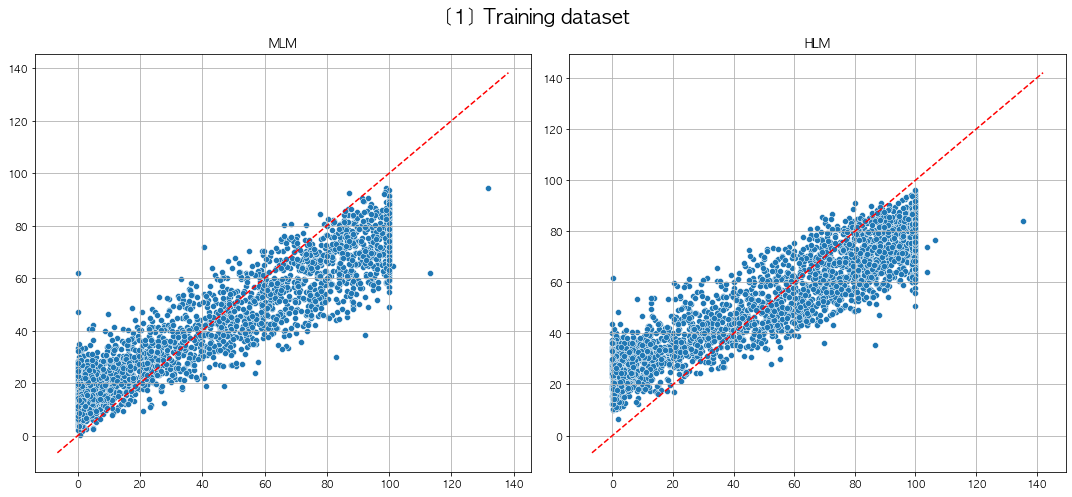

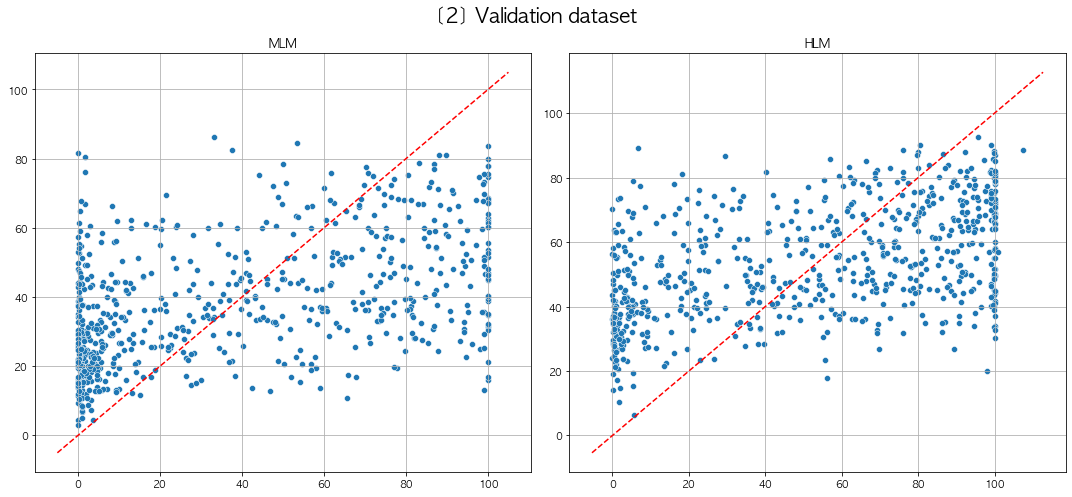

----------------------------------------------------------------------------------------------------
> [K-Fold] 2/5
----------------------------------------------------------------------------------------------------
[1/10] ElasticNet : loss=30.792, val_loss=33.406, elasped=6.9s
[2/10] XGBoost    : loss=6.987, val_loss=32.702, elasped=241.0s
[3/10] LightGBM   : loss=19.192, val_loss=31.890, elasped=96.6s
[4/10] ExtraTrees : loss=19.189, val_loss=32.250, elasped=27.7s
[5/10] CatBoost1  : loss=20.243, val_loss=31.783, elasped=63.8s
[6/10] CatBoost2  : loss=21.875, val_loss=31.890, elasped=55.2s
[7/10] CatBoost3  : loss=21.923, val_loss=31.766, elasped=59.9s
[8/10] CatBoost4  : loss=13.531, val_loss=31.531, elasped=112.3s
[9/10] CatBoost5  : loss=12.989, val_loss=31.591, elasped=141.3s
[10/10] CatBoost6  : loss=15.964, val_loss=31.670, elasped=127.3s
<Weighted Ensemble(weight='balanced')> loss=17.797, val_loss=31.672, elasped=932.1s


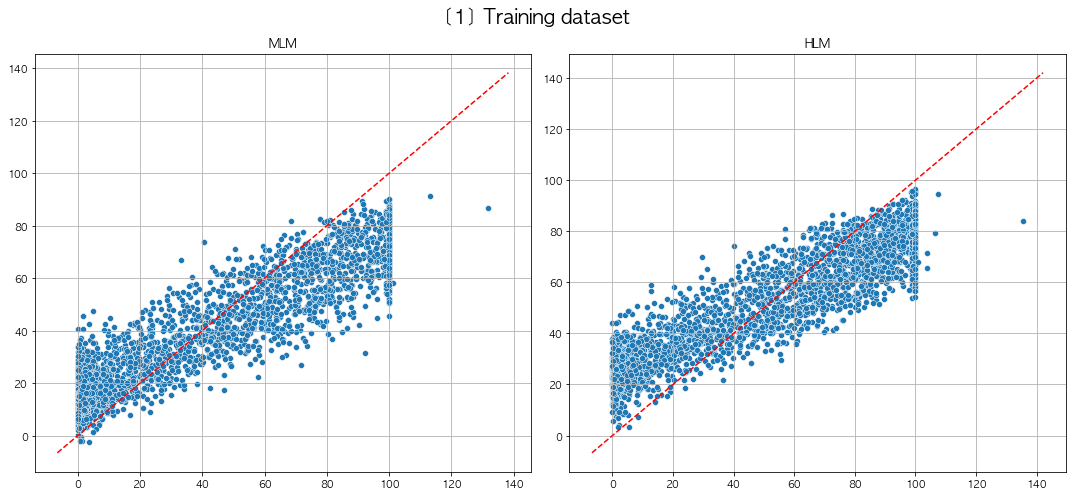

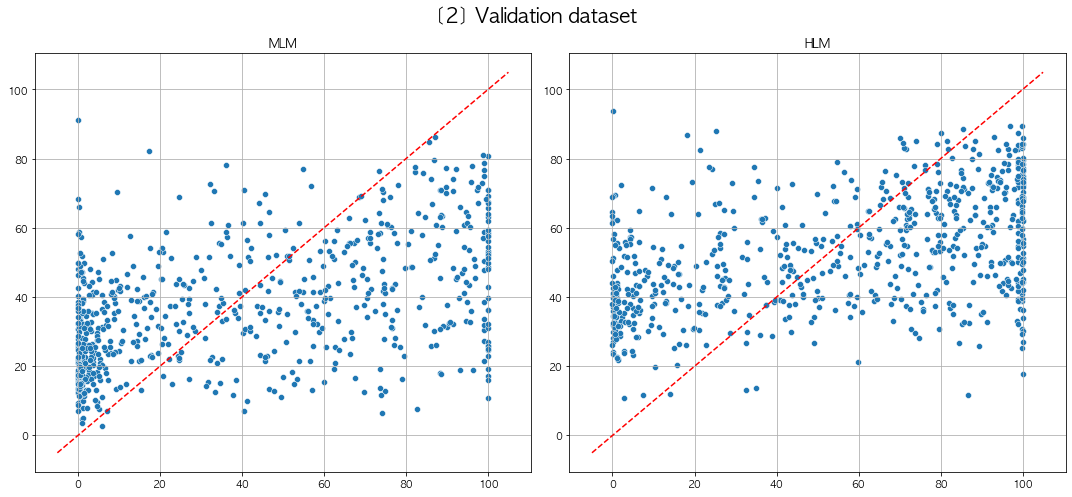

----------------------------------------------------------------------------------------------------
> [K-Fold] 3/5
----------------------------------------------------------------------------------------------------
[1/10] ElasticNet : loss=30.265, val_loss=31.183, elasped=7.2s
[2/10] XGBoost    : loss=12.229, val_loss=31.846, elasped=33.6s
[3/10] LightGBM   : loss=21.636, val_loss=30.849, elasped=21.2s
[4/10] ExtraTrees : loss=19.735, val_loss=31.127, elasped=26.4s
[5/10] CatBoost1  : loss=22.578, val_loss=30.545, elasped=45.2s
[6/10] CatBoost2  : loss=24.482, val_loss=30.561, elasped=39.8s
[7/10] CatBoost3  : loss=22.639, val_loss=30.541, elasped=55.3s
[8/10] CatBoost4  : loss=17.209, val_loss=30.489, elasped=85.6s
[9/10] CatBoost5  : loss=19.247, val_loss=30.499, elasped=85.4s
[10/10] CatBoost6  : loss=20.474, val_loss=30.365, elasped=83.3s
<Weighted Ensemble(weight='balanced')> loss=20.684, val_loss=30.441, elasped=483.0s


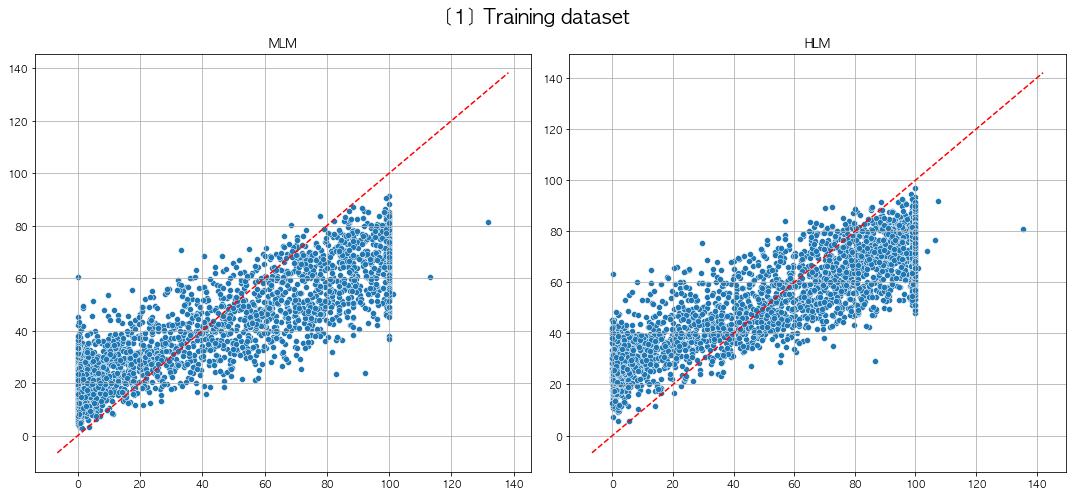

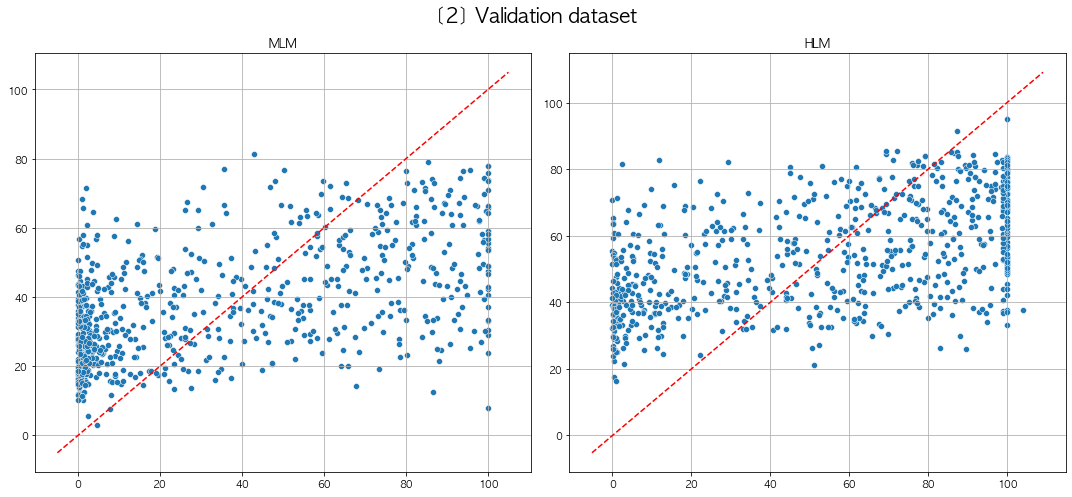

----------------------------------------------------------------------------------------------------
> [K-Fold] 4/5
----------------------------------------------------------------------------------------------------
[1/10] ElasticNet : loss=31.124, val_loss=32.021, elasped=7.0s
[2/10] XGBoost    : loss=8.620, val_loss=31.310, elasped=47.5s
[3/10] LightGBM   : loss=22.455, val_loss=30.948, elasped=17.9s
[4/10] ExtraTrees : loss=20.004, val_loss=31.016, elasped=26.4s
[5/10] CatBoost1  : loss=20.212, val_loss=30.537, elasped=60.8s
[6/10] CatBoost2  : loss=23.028, val_loss=30.618, elasped=50.1s
[7/10] CatBoost3  : loss=23.363, val_loss=30.575, elasped=51.5s
[8/10] CatBoost4  : loss=15.161, val_loss=30.491, elasped=100.2s
[9/10] CatBoost5  : loss=18.571, val_loss=30.414, elasped=90.5s
[10/10] CatBoost6  : loss=18.775, val_loss=30.413, elasped=98.1s
<Weighted Ensemble(weight='balanced')> loss=19.707, val_loss=30.458, elasped=550.1s


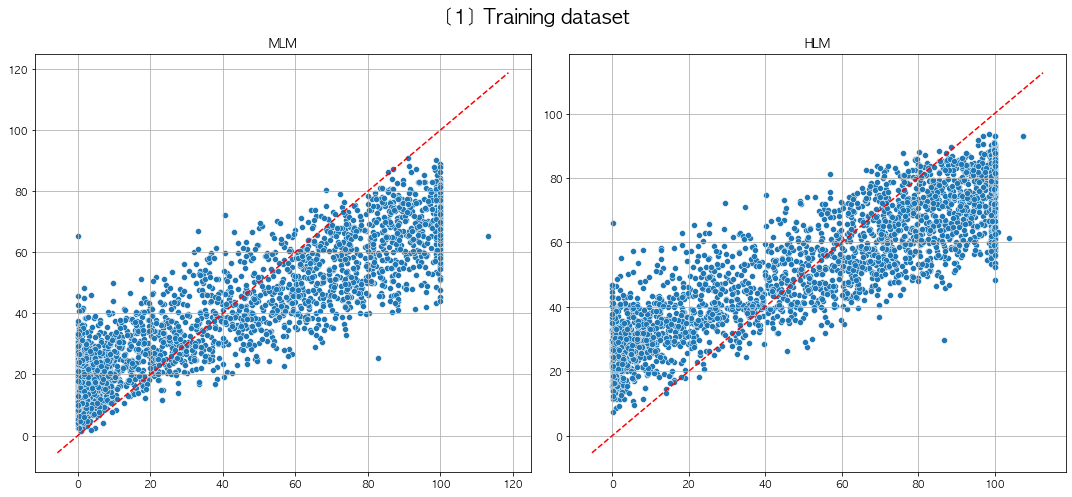

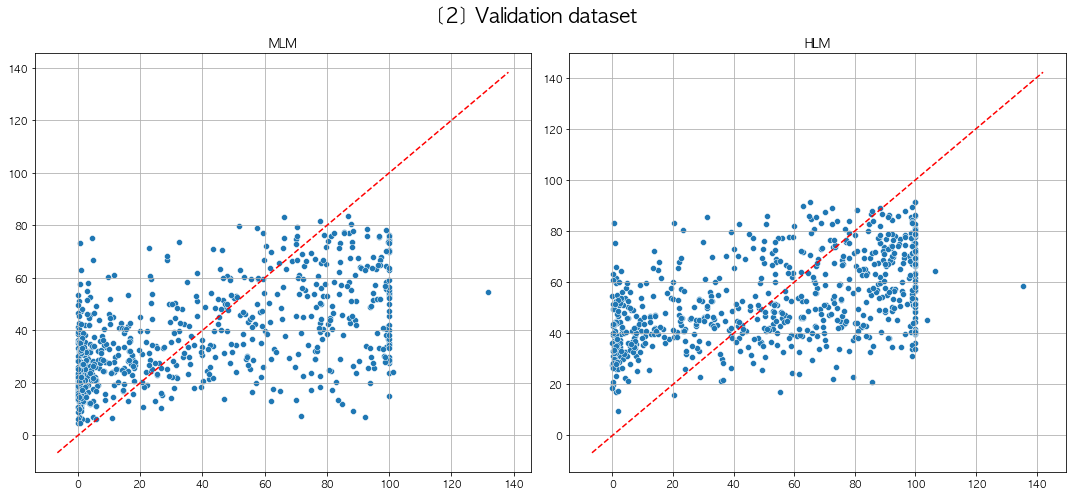

----------------------------------------------------------------------------------------------------
> [K-Fold] 5/5
----------------------------------------------------------------------------------------------------
[1/10] ElasticNet : loss=29.998, val_loss=32.705, elasped=7.2s
[2/10] XGBoost    : loss=7.771, val_loss=31.908, elasped=50.3s
[3/10] LightGBM   : loss=23.426, val_loss=31.529, elasped=17.3s
[4/10] ExtraTrees : loss=19.178, val_loss=31.609, elasped=26.8s
[5/10] CatBoost1  : loss=22.529, val_loss=31.524, elasped=45.1s
[6/10] CatBoost2  : loss=24.409, val_loss=31.464, elasped=39.3s
[7/10] CatBoost3  : loss=25.191, val_loss=31.495, elasped=38.0s
[8/10] CatBoost4  : loss=17.733, val_loss=31.271, elasped=80.4s
[9/10] CatBoost5  : loss=20.808, val_loss=31.269, elasped=73.7s
[10/10] CatBoost6  : loss=20.972, val_loss=31.243, elasped=79.9s
<Weighted Ensemble(weight='balanced')> loss=20.835, val_loss=31.248, elasped=457.9s


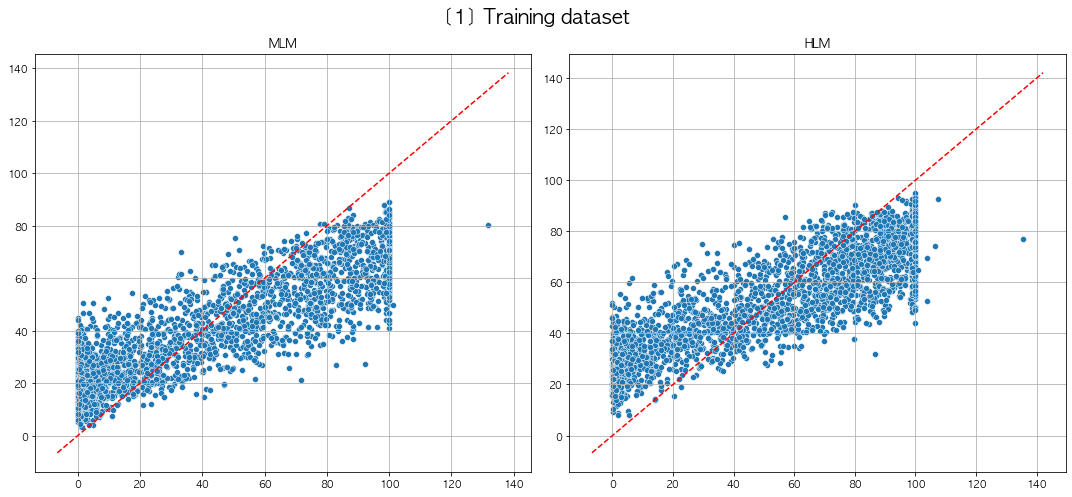

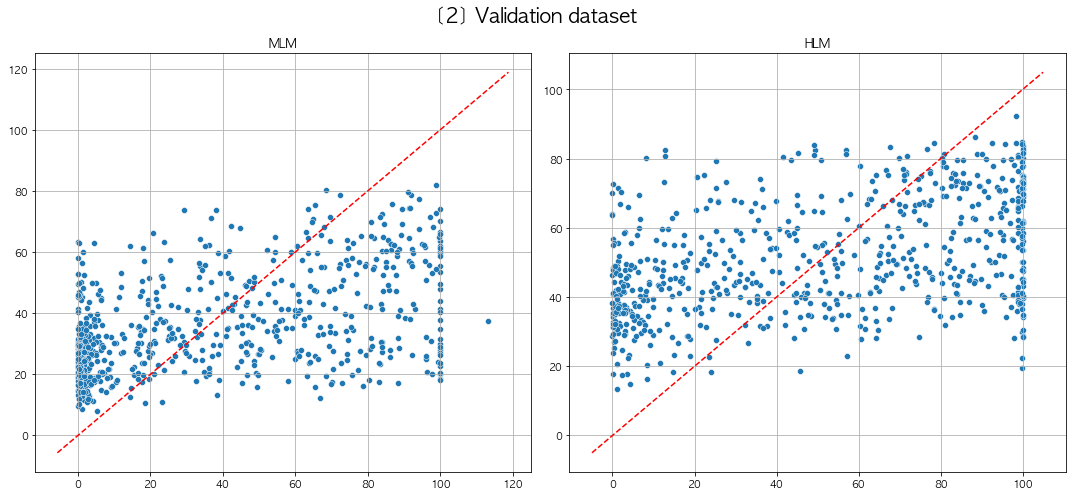

CPU times: user 4h 11min 14s, sys: 24min 49s, total: 4h 36min 3s
Wall time: 1h 6min 17s


In [61]:
%%time

save_path = './mc/kf_weiens_catall/k{}.pickle'
gc_collect_all(verbose=False)

# kfold
kf = KFold(n_splits=CFG.N_SPLITS,random_state=CFG.SEED,shuffle=True)

models = []
scores = []
k=0
for tr_idx,val_idx in kf.split(X,y):
    k+=1
    
    print('-'*100)
    print('> [K-Fold] {}/{}'.format(k,CFG.N_SPLITS))
    print('-'*100)
    
    # kfold dataset
    X_tr, X_va = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[val_idx]

    # define the model
    ensemble_model = WeightedEnsembleRegressor(
        hyperparameters=hyperparameters,
        weight='balanced',
        inverse_transform=inverse_transform,
    )

    # fit the model
    ensemble_model.fit(
        X_tr,y_tr,
        eval_set=[(X_va,y_va)],
        oh_set=[(X_tr,X_va)],
        cat_features=[],
        verbose=0,
    )

    # save the model
    ensemble_model.save_model(save_path.format(k))
    tr_pred = ensemble_model.predict(X_tr,X_tr)
    va_pred = ensemble_model.predict(X_va,X_va)
    
    if inverse_transform is not None:
        tr_true = inverse_transform(y_tr)
        va_true = inverse_transform(y_va)
    else:
        tr_true = np.array(y_tr)
        va_true = np.array(y_va)

    # train
    fig = plt.figure(figsize=(15,7))
    fig.add_subplot(121)
    sns.scatterplot(x=tr_true[:,0],y=tr_pred[:,0])
    abline(0,1)
    plt.grid()
    plt.title(CFG.TARGET[0])
    fig.add_subplot(122)
    sns.scatterplot(x=tr_true[:,1],y=tr_pred[:,1])
    abline(0,1)
    plt.grid()
    plt.title(CFG.TARGET[1])
    plt.suptitle('[1] Training dataset',fontsize=20)
    plt.tight_layout()
    plt.show()

    # validation
    fig = plt.figure(figsize=(15,7))
    fig.add_subplot(121)
    sns.scatterplot(x=va_true[:,0],y=va_pred[:,0])
    abline(0,1)
    plt.grid()
    plt.title(CFG.TARGET[0])
    fig.add_subplot(122)
    sns.scatterplot(x=va_true[:,1],y=va_pred[:,1])
    abline(0,1)
    plt.grid()
    plt.title(CFG.TARGET[1])
    plt.suptitle('[2] Validation dataset',fontsize=20)
    plt.tight_layout()
    plt.show()

    # caculate score
    score_1 = mean_squared_error(y_true=va_true[:,0],y_pred=va_pred[:,0])**0.5
    score_2 = mean_squared_error(y_true=va_true[:,1],y_pred=va_pred[:,1])**0.5
    score = 0.5*score_1+0.5*score_2

    # append inner loop
    models.append(ensemble_model)
    scores.append([k,len(X_tr),len(X_va),score])

In [62]:
pd.DataFrame(va_pred).isnull().sum()

0    0
1    0
dtype: int64

In [63]:
# !!!inverse boxcox 후, prediction에 Null이 생기는 경우에는 어떻게할지?

In [64]:
score_df = pd.DataFrame(scores,columns=['k','n_train','n_val','rmse'])
score_df

,k,n_train,n_val,rmse
0,1,2798,700,31.222920
1,2,2798,700,31.672247
2,3,2798,700,30.441137
3,4,2799,699,30.457682
4,5,2799,699,31.248474


In [65]:
X      = train_fn.drop(CFG.TARGET,axis=1)
X_test = test_fn.copy()

y = train_fn[CFG.TARGET]

In [66]:
# cat_features = ['Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds']
# X     [cat_features] = X     [cat_features].astype(str)
# X_test[cat_features] = X_test[cat_features].astype(str)

In [67]:
path = './mc/kf_weiens_catall/k{}.pickle'
model_list = [load_model(hyperparameters,path.format(k)) for k in range(1,6)]

features = model_list[0].features
oh_features = model_list[0].oh_features

tr_pred = np.mean([model.predict(X[features],X[oh_features]) for model in model_list],axis=0)
tr_pred = pd.DataFrame(tr_pred,index=X.index)

te_pred = np.mean([model.predict(X_test[features],X_test[oh_features]) for model in model_list],axis=0)
te_pred = pd.DataFrame(te_pred,index=X_test.index)

In [68]:
def multi_rmse(y_true,y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    rmse_list = []
    for i in range(y_true.shape[1]):
        rmse = mean_squared_error(y_true=y_true[:,i],y_pred=y_pred[:,i])**0.5
        rmse_list.append(rmse)
    
    return np.mean(rmse_list)

In [69]:
def set_0to100(x):
    x = np.array(x)
    return [0 if _x<0 else
            100 if _x>100 else
            _x for _x in x]

In [70]:
# tr_pred = tr_pred.apply(set_0to100)
# te_pred = pd.DataFrame(target_transform.inverse_transform(y)).apply(set_0to100)

In [71]:
multi_rmse(y_true=tr_pred,y_pred=y)

21.459179748858798

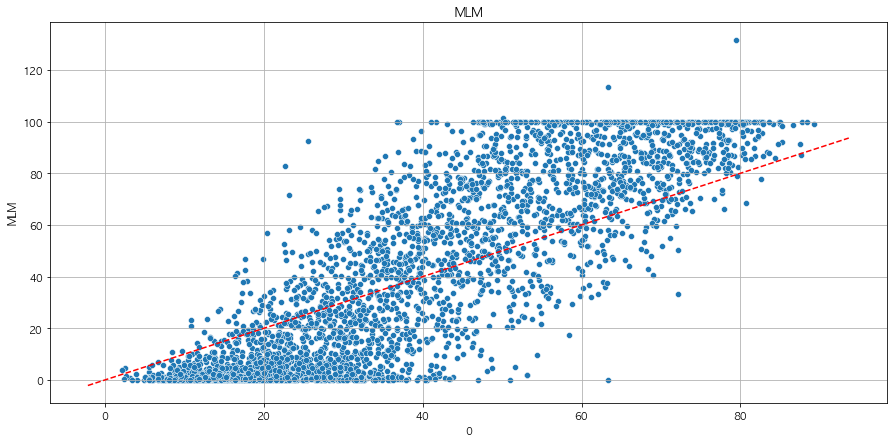

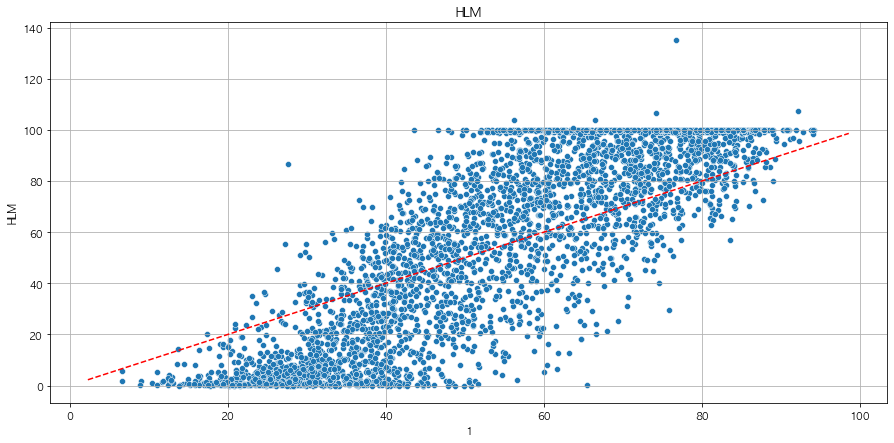

In [72]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=tr_pred.iloc[:,0],y=y.iloc[:,0])
abline(0,1)
plt.grid()
plt.title('MLM')
plt.show()

plt.figure(figsize=(15,7))
sns.scatterplot(x=tr_pred.iloc[:,1],y=y.iloc[:,1])
abline(0,1)
plt.grid()
plt.title('HLM')
plt.show()

In [73]:
submit = pd.read_csv('./data/sample_submission.csv')
submit[CFG.TARGET] = te_pred

In [74]:
submit.tail()

,id,MLM,HLM
478,TEST_478,9.354684,27.558158
479,TEST_479,74.804053,85.402702
480,TEST_480,38.366377,59.351130
481,TEST_481,60.588085,75.158741
482,TEST_482,33.268013,59.992578


In [75]:
# public :  (identity)
submit.to_csv('./out/8_weiens_seg_catall_ensmodel10개.csv',index=False)

<br>

## Stacking

In [76]:
X      = train_fn.drop(CFG.TARGET,axis=1)
X_test = test_fn.copy()

y = train_fn[CFG.TARGET]

# kfold
kf = KFold(n_splits=CFG.N_SPLITS,random_state=CFG.SEED,shuffle=True)

# unique인 컬럼 제외
# (1) X
unique_info = X.nunique()
unique_cols = unique_info[unique_info==1].index.tolist()
if len(unique_cols)>0:
    X = X.drop(unique_cols,axis=1)

In [77]:
org_path = './mc/kf_weiens_catall/k{}.pickle'
model_list = [load_model(hyperparameters,org_path.format(k)) for k in range(1,6)]

features    = model_list[0].features
oh_features = model_list[0].oh_features
X = X[features]
X_test = X_test[features]

tr_pred = pd.DataFrame(index=X.index)
te_pred = pd.DataFrame(index=X_test.index)

tr_pred[['pred1','pred2']] = np.mean([model.predict(X     ,X     ) for i,model in enumerate(model_list,1)],axis=0)
te_pred[['pred1','pred2']] = np.mean([model.predict(X_test,X_test) for i,model in enumerate(model_list,1)],axis=0)

# for i,model in enumerate(model_list,1):
#     tr_pred[[f'pred{i}1',f'pred{i}2']] = model.predict(X,X)
#     te_pred[[f'pred{i}1',f'pred{i}2']] = model.predict(X_test,X_test)

X_new      = pd.concat([X      ,tr_pred],axis=1)
X_test_new = pd.concat([X_test ,te_pred],axis=1)

----------------------------------------------------------------------------------------------------
> [K-Fold] 1/5
----------------------------------------------------------------------------------------------------
[1/6] CatBoost1  : loss=2.969, val_loss=11.119, elasped=376.0s
[2/6] CatBoost2  : loss=2.920, val_loss=11.002, elasped=516.5s
[3/6] CatBoost3  : loss=3.045, val_loss=10.891, elasped=515.6s
[4/6] CatBoost4  : loss=2.612, val_loss=12.053, elasped=850.6s
[5/6] CatBoost5  : loss=2.649, val_loss=11.822, elasped=839.5s
[6/6] CatBoost6  : loss=2.672, val_loss=11.613, elasped=873.2s
<Weighted Ensemble(weight='balanced')> loss=2.786, val_loss=11.336, elasped=3971.2s


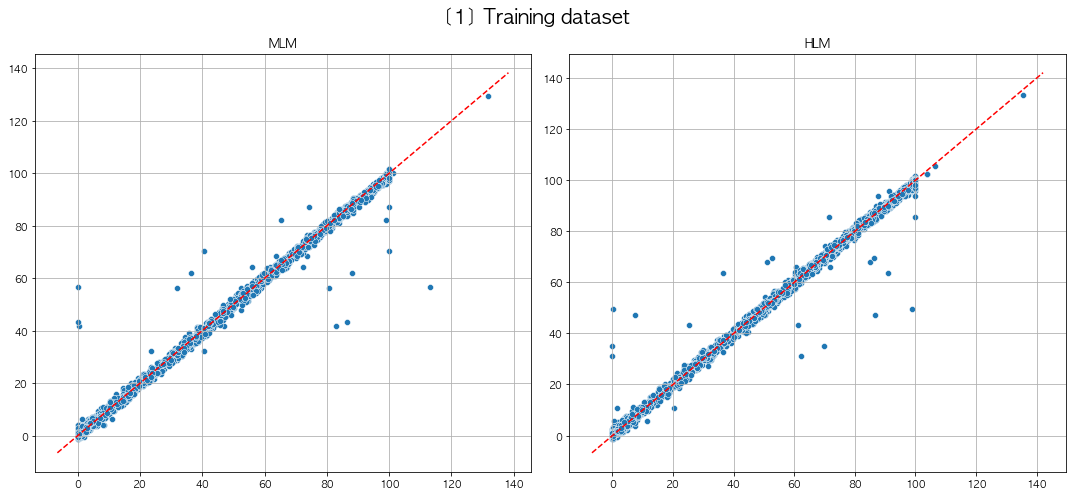

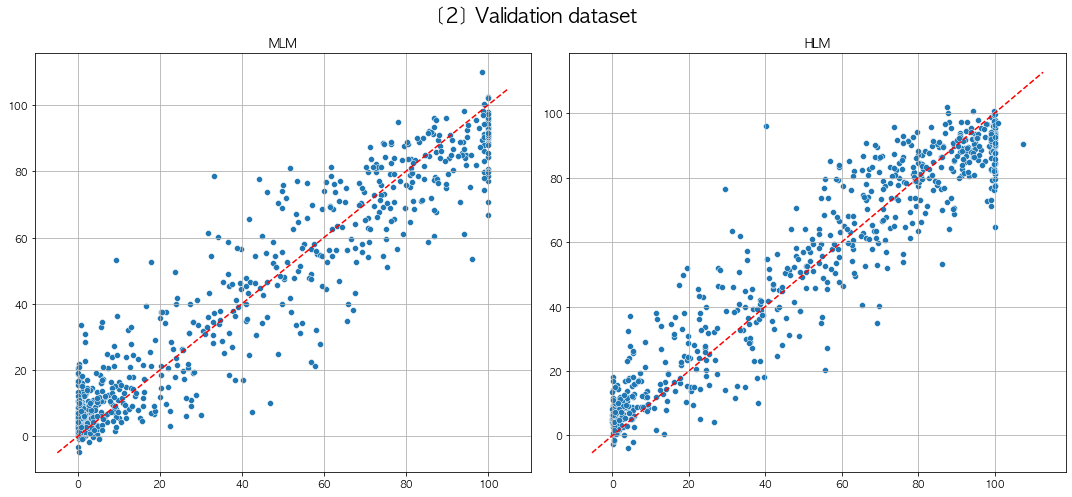

----------------------------------------------------------------------------------------------------
> [K-Fold] 2/5
----------------------------------------------------------------------------------------------------
[1/6] CatBoost1  : loss=3.325, val_loss=12.065, elasped=162.4s
[2/6] CatBoost2  : loss=3.827, val_loss=11.962, elasped=167.5s
[3/6] CatBoost3  : loss=3.580, val_loss=11.841, elasped=212.8s
[4/6] CatBoost4  : loss=2.388, val_loss=12.832, elasped=185.7s
[5/6] CatBoost5  : loss=2.948, val_loss=12.598, elasped=198.3s
[6/6] CatBoost6  : loss=2.928, val_loss=12.467, elasped=234.2s
<Weighted Ensemble(weight='balanced')> loss=3.146, val_loss=12.225, elasped=1160.8s


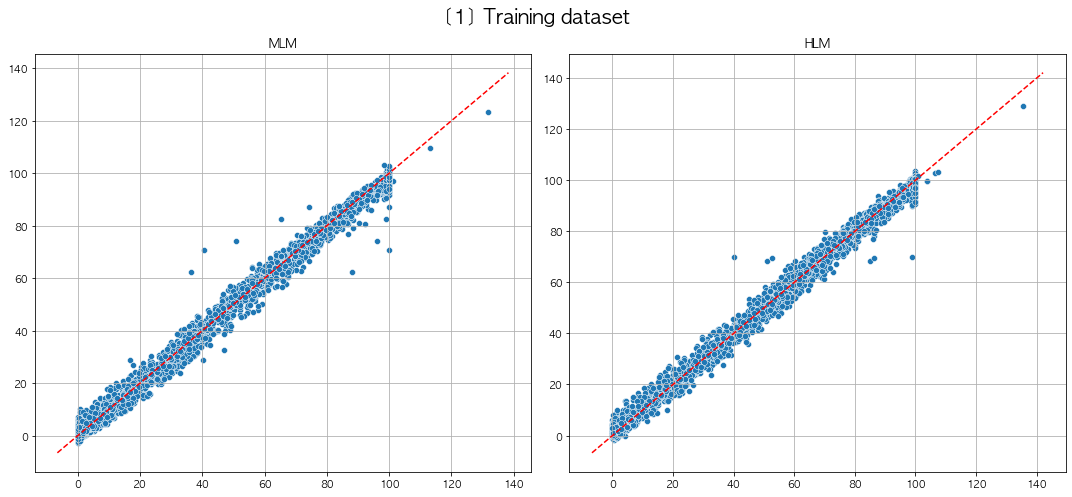

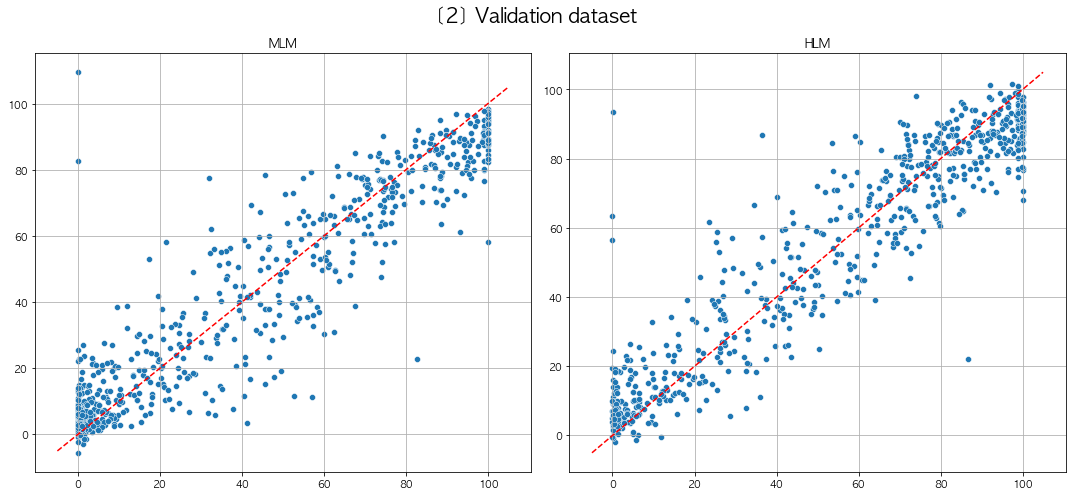

----------------------------------------------------------------------------------------------------
> [K-Fold] 3/5
----------------------------------------------------------------------------------------------------
[1/6] CatBoost1  : loss=4.242, val_loss=10.593, elasped=141.6s
[2/6] CatBoost2  : loss=4.440, val_loss=10.435, elasped=165.3s
[3/6] CatBoost3  : loss=4.352, val_loss=10.379, elasped=196.9s
[4/6] CatBoost4  : loss=3.412, val_loss=11.371, elasped=157.0s
[5/6] CatBoost5  : loss=3.514, val_loss=11.074, elasped=196.1s
[6/6] CatBoost6  : loss=3.833, val_loss=10.917, elasped=202.6s
<Weighted Ensemble(weight='balanced')> loss=3.948, val_loss=10.723, elasped=1059.4s


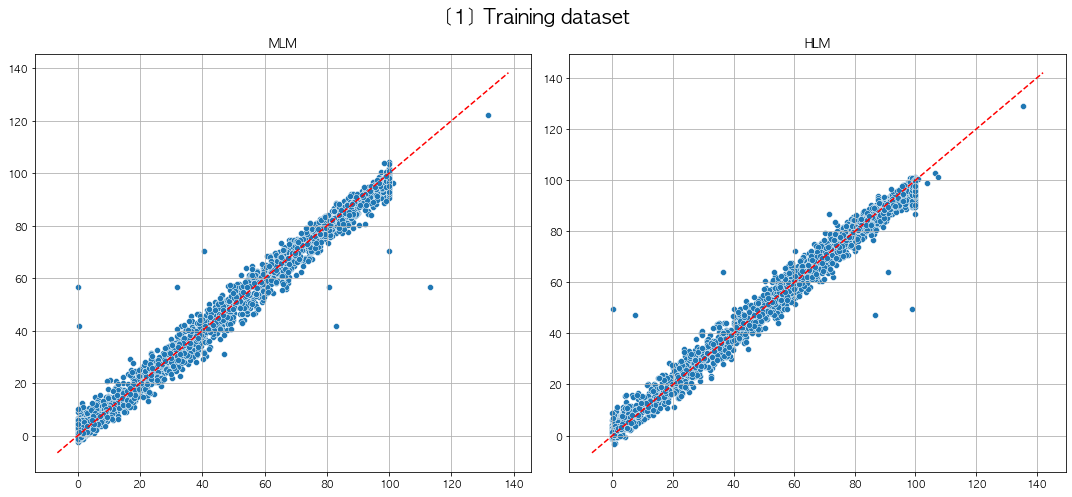

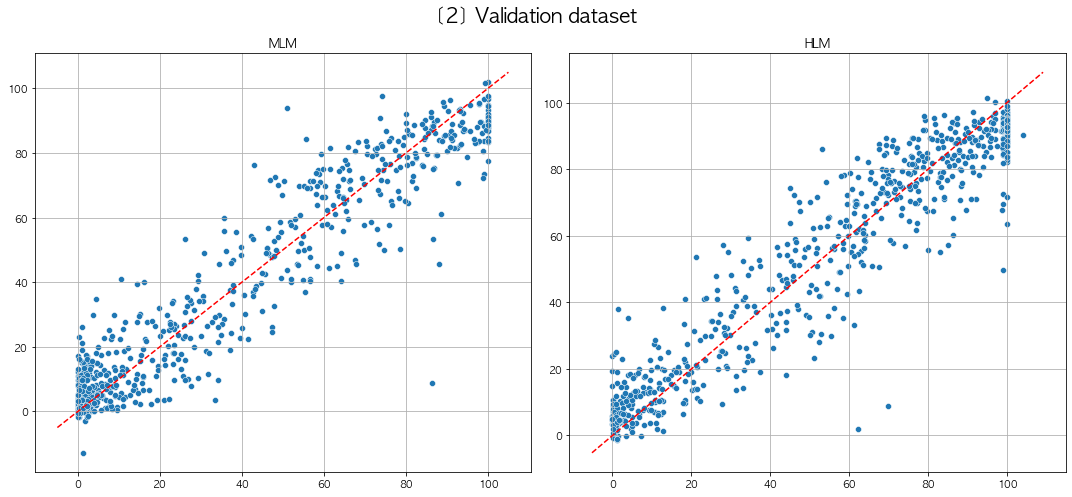

----------------------------------------------------------------------------------------------------
> [K-Fold] 4/5
----------------------------------------------------------------------------------------------------
[1/6] CatBoost1  : loss=3.031, val_loss=10.716, elasped=337.8s
[2/6] CatBoost2  : loss=3.288, val_loss=10.591, elasped=351.1s
[3/6] CatBoost3  : loss=3.005, val_loss=10.418, elasped=518.9s
[4/6] CatBoost4  : loss=2.582, val_loss=11.465, elasped=639.7s
[5/6] CatBoost5  : loss=2.622, val_loss=11.234, elasped=686.2s
[6/6] CatBoost6  : loss=2.614, val_loss=11.037, elasped=862.1s
<Weighted Ensemble(weight='balanced')> loss=2.811, val_loss=10.837, elasped=3395.9s


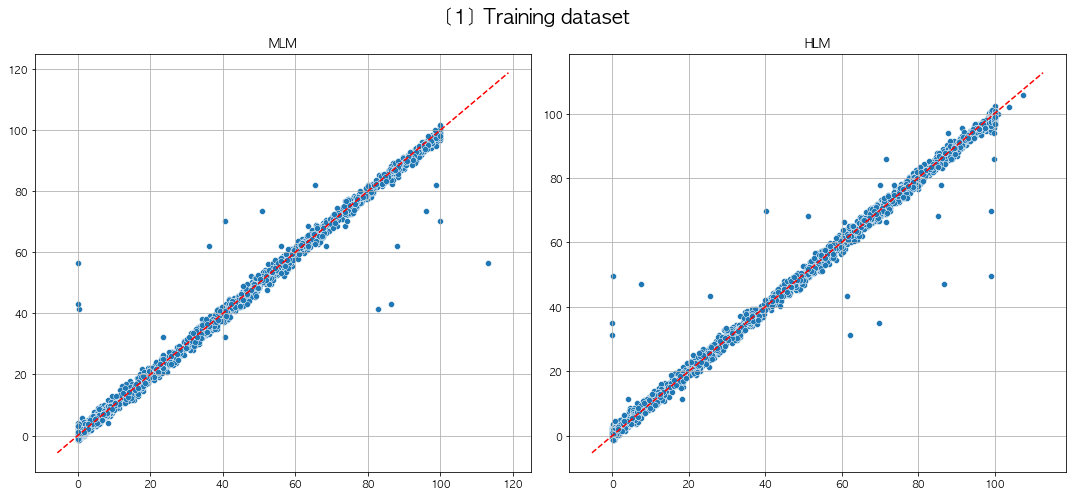

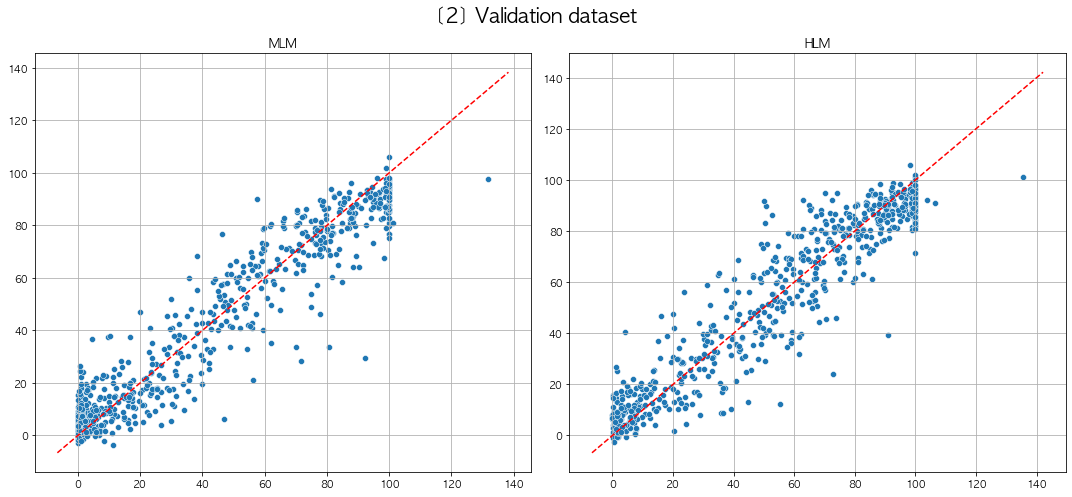

----------------------------------------------------------------------------------------------------
> [K-Fold] 5/5
----------------------------------------------------------------------------------------------------
[1/6] CatBoost1  : loss=2.296, val_loss=10.624, elasped=514.9s
[2/6] CatBoost2  : loss=2.731, val_loss=10.523, elasped=394.7s
[3/6] CatBoost3  : loss=2.989, val_loss=10.422, elasped=383.3s
[4/6] CatBoost4  : loss=2.073, val_loss=11.443, elasped=935.9s
[5/6] CatBoost5  : loss=2.090, val_loss=11.188, elasped=1013.0s
[6/6] CatBoost6  : loss=2.500, val_loss=11.010, elasped=423.8s
<Weighted Ensemble(weight='balanced')> loss=2.383, val_loss=10.782, elasped=3665.6s


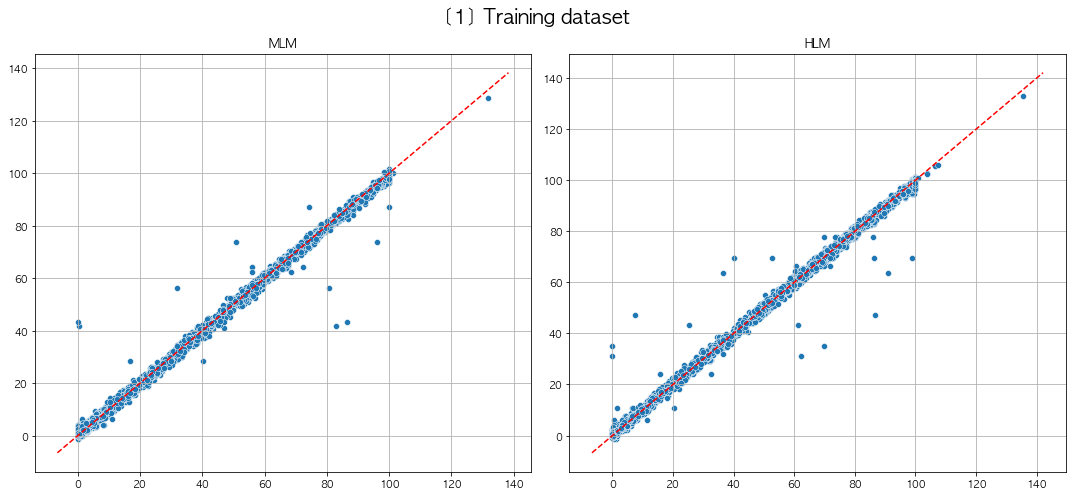

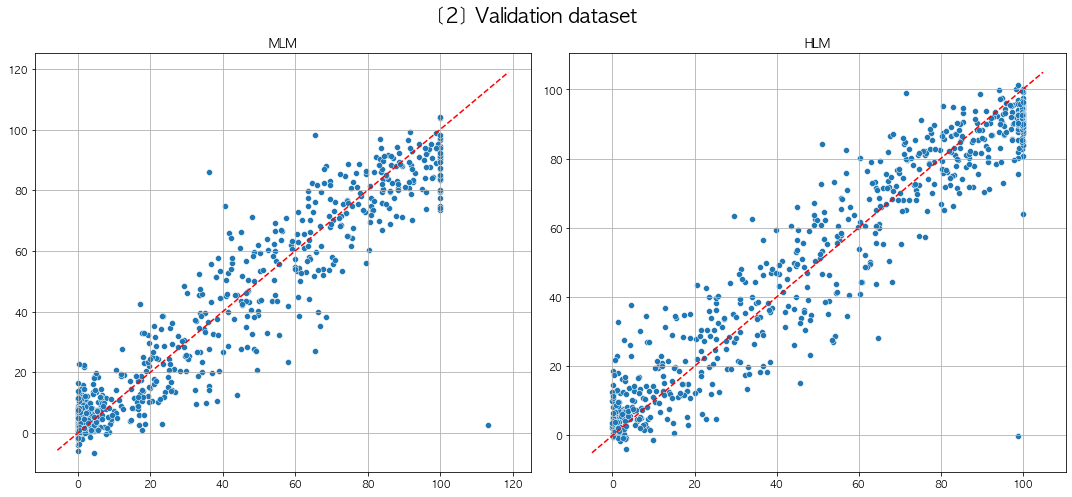

CPU times: user 18h 20min 59s, sys: 1h 56min 47s, total: 20h 17min 46s
Wall time: 3h 41min 11s


In [78]:
%%time

save_path = './mc/kf_weiens_catall/stacking_k{}.pickle'

gc_collect_all(verbose=False)

models = []
scores = []
k=0
for tr_idx,val_idx in kf.split(X,y):
    k+=1
    
    print('-'*100)
    print('> [K-Fold] {}/{}'.format(k,CFG.N_SPLITS))
    print('-'*100)
    
    # kfold dataset
    X_tr, X_va = X_new.iloc[tr_idx], X_new.iloc[val_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[val_idx]

    # define the model
    ensemble_model = WeightedEnsembleRegressor(
        hyperparameters=hyperparameters,
        weight='balanced',
        inverse_transform=inverse_transform,
    )
    # cat만 가져오기
    ensemble_model.regressors = ensemble_model.regressors[-6:]
    ensemble_model.regressors_name = ensemble_model.regressors_name[-6:]

    # fit the model
    ensemble_model.fit(
        X_tr,y_tr,
        eval_set=[(X_va,y_va)],
        oh_set=[(X_tr,X_va)],
        cat_features=[],
        verbose=0,
    )

    # save the model
    ensemble_model.save_model(save_path.format(k))
    tr_pred = ensemble_model.predict(X_tr,X_tr)
    va_pred = ensemble_model.predict(X_va,X_va)

    if inverse_transform is not None:
        tr_true = inverse_transform(y_tr)
        va_true = inverse_transform(y_va)
    else:
        tr_true = np.array(y_tr)
        va_true = np.array(y_va)

    # train
    fig = plt.figure(figsize=(15,7))
    fig.add_subplot(121)
    sns.scatterplot(x=tr_true[:,0],y=tr_pred[:,0])
    abline(0,1)
    plt.grid()
    plt.title(CFG.TARGET[0])
    fig.add_subplot(122)
    sns.scatterplot(x=tr_true[:,1],y=tr_pred[:,1])
    abline(0,1)
    plt.grid()
    plt.title(CFG.TARGET[1])
    plt.suptitle('[1] Training dataset',fontsize=20)
    plt.tight_layout()
    plt.show()

    # validation
    fig = plt.figure(figsize=(15,7))
    fig.add_subplot(121)
    sns.scatterplot(x=va_true[:,0],y=va_pred[:,0])
    abline(0,1)
    plt.grid()
    plt.title(CFG.TARGET[0])
    fig.add_subplot(122)
    sns.scatterplot(x=va_true[:,1],y=va_pred[:,1])
    abline(0,1)
    plt.grid()
    plt.title(CFG.TARGET[1])
    plt.suptitle('[2] Validation dataset',fontsize=20)
    plt.tight_layout()
    plt.show()

    # caculate score
    score_1 = mean_squared_error(y_true=va_true[:,0],y_pred=va_pred[:,0])**0.5
    score_2 = mean_squared_error(y_true=va_true[:,1],y_pred=va_pred[:,1])**0.5
    score = 0.5*score_1+0.5*score_2

    # append inner loop
    models.append(ensemble_model)
    scores.append([k,len(X_tr),len(X_va),score])

In [79]:
score_df = pd.DataFrame(scores,columns=['k','n_train','n_val','rmse'])
score_df

,k,n_train,n_val,rmse
0,1,2798,700,11.335922
1,2,2798,700,12.225314
2,3,2798,700,10.722679
3,4,2799,699,10.836737
4,5,2799,699,10.781883


In [80]:
X      = train_fn.drop(CFG.TARGET,axis=1)
X_test = test_fn.copy()

y = train_fn[CFG.TARGET]

# kfold
kf = KFold(n_splits=CFG.N_SPLITS,random_state=CFG.SEED,shuffle=True)

# unique인 컬럼 제외
# (1) X
unique_info = X.nunique()
unique_cols = unique_info[unique_info==1].index.tolist()
if len(unique_cols)>0:
    X = X.drop(unique_cols,axis=1)

In [81]:
model_list = [load_model(hyperparameters,org_path.format(k)) for k in range(1,6)]

features    = model_list[0].features
oh_features = model_list[0].oh_features
X = X[features]
X_test = X_test[features]

tr_pred = pd.DataFrame(index=X.index)
te_pred = pd.DataFrame(index=X_test.index)

tr_pred[['pred1','pred2']] = np.mean([model.predict(X     ,X     ) for i,model in enumerate(model_list,1)],axis=0)
te_pred[['pred1','pred2']] = np.mean([model.predict(X_test,X_test) for i,model in enumerate(model_list,1)],axis=0)

# for i,model in enumerate(model_list,1):
#     tr_pred[[f'pred{i}1',f'pred{i}2']] = model.predict(X,X)
#     te_pred[[f'pred{i}1',f'pred{i}2']] = model.predict(X_test,X_test)

X_new      = pd.concat([X      ,tr_pred],axis=1)
X_test_new = pd.concat([X_test ,te_pred],axis=1)

In [82]:
stacking_path = './mc/kf_weiens_catall/stacking_k{}.pickle'
model_list = [load_model(hyperparameters,stacking_path.format(k)) for k in range(1,6)]

features = model_list[0].features
oh_features = model_list[0].oh_features

tr_pred = np.mean([model.predict(X_new[features],X_new[oh_features]) for model in model_list],axis=0)
tr_pred = pd.DataFrame(tr_pred,index=X.index)

te_pred = np.mean([model.predict(X_test_new[features],X_test_new[oh_features]) for model in model_list],axis=0)
te_pred = pd.DataFrame(te_pred,index=X_test.index)

In [83]:
# tr_pred = tr_pred.apply(set_0to100)
# te_pred = pd.DataFrame(target_transform.inverse_transform(y)).apply(set_0to100)

In [84]:
multi_rmse(y_true=tr_pred,y_pred=y)

4.25919468652264

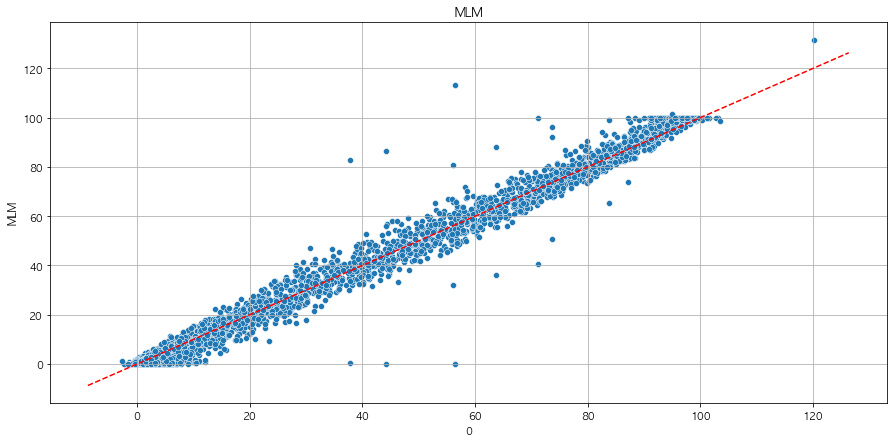

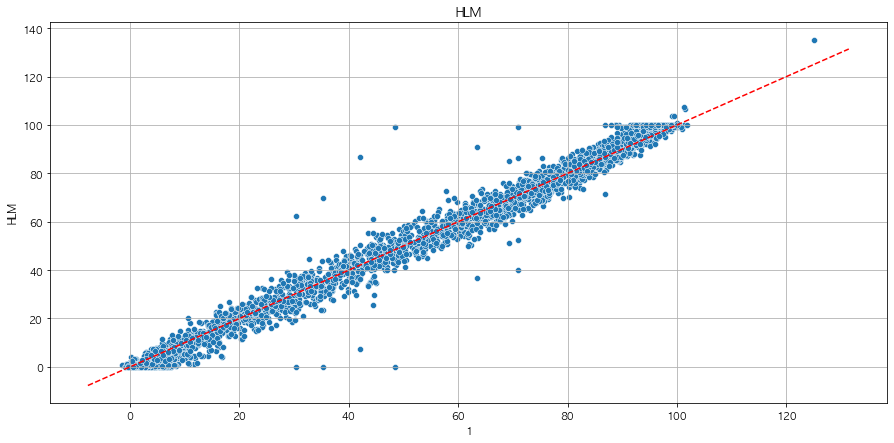

In [85]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=tr_pred.iloc[:,0],y=y.iloc[:,0])
abline(0,1)
plt.grid()
plt.title('MLM')
plt.show()

plt.figure(figsize=(15,7))
sns.scatterplot(x=tr_pred.iloc[:,1],y=y.iloc[:,1])
abline(0,1)
plt.grid()
plt.title('HLM')
plt.show()

In [86]:
submit = pd.read_csv('./data/sample_submission.csv')
submit[CFG.TARGET] = te_pred

In [87]:
submit.head()

,id,MLM,HLM
0,TEST_000,9.380847,46.617170
1,TEST_001,82.272247,90.851831
2,TEST_002,39.545538,38.101221
3,TEST_003,59.646342,80.315132
4,TEST_004,69.900098,82.152302


In [88]:
# public : 29.0213247731 (identity)
submit.to_csv('./out/9_weiens_seg_catall_stacking_ensmodel10개.csv',index=False)